In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
contracts = pd.read_csv('contracts.csv')
donations = pd.read_csv('donations.csv')

The contracts table contains government contracts granted to industry, and the Agency column tells us which government department awarded the contract. The donations table contains donations to political parties from various private and industry donors.

Links can be made between a political party and a government department by considering individual party members who have served as ministers of the relevant department, and other things (see Resource2). 

Let us suppose that we have found a link between the Department of Infrastructure, Transport, Regional Development and Local Government, and representatives of the National Party. Here we will show how this link might be exploited to examine whether industry donations could be influencing the granting of contracts to industry suppliers.

We start by getting the names of the top suppliers and top donors from each table:

In [2]:
PARTY = r'National Party'
AGENCY = 'Department of Infrastructure Transport Regional ' \
         'Development and Local Government'

df1 = contracts[contracts['agency_name'] == AGENCY]

df1 = df1[['supplier_name','value']].sort_values('value', ascending=False)

topsuppliers = df1['supplier_name'][:1000].unique().tolist()

df2 = donations[donations['ent_name'].str.contains(PARTY)]

df2 = df2[['donor','value']].sort_values('value', ascending=False)

topdonors = df2['donor'][:1000].unique().tolist()

We need a way to compare names across the two lists. For the moment we do a quick and dirty comparison of the words in each name, excluding common words.

In [3]:
def similar_names(a, b, threshold = 1):
    names1 = []
    names2 = []
    for name1 in a:
        for name2 in b:
            words1 = name1.lower().split()
            words2 = name2.lower().split()
            for w in ['constructions', 
                      'services', 
                      'group', 
                      '&', 
                      'pty', 
                      'ltd', 
                      'limited', 
                      'trust', 
                      'bank', 
                      'and', 
                      'australia',
                      'australian']:
                if w in words1:
                    words1.remove(w)
                if w in words2:
                    words2.remove(w)
            common = set(words1).intersection(words2)
            if len(common) >= threshold:
                names1.append(name1)
                names2.append(name2)
    return names1, names2

Now we can merge the tables of contracts and donations based on similar supplier/donor names. 

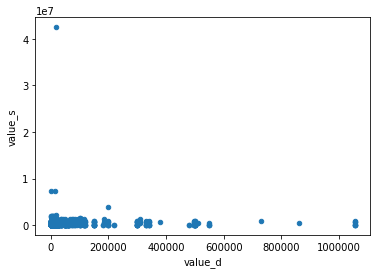

In [4]:
[s, d] = similar_names(topsuppliers, topdonors)

top_id = [d.index(i) if i in d else np.nan for i in df2['donor']]

df2 = df2.assign( **{ 'top_id' : top_id } ) 

top_id = [s.index(i) if i in s else np.nan for i in df1['supplier_name']]

df1 = df1.assign( **{ 'top_id' : top_id } )

df3 = pd.merge(df2, df1, on='top_id', how='inner', suffixes = ('_d','_s'))

df3 = df3.dropna()

df3.plot(x='value_d', y='value_s', kind='scatter')

Data points to look for are ones that are both high donors and highly awarded suppliers.

We can also consider how contracts are awarded to the possible donor/suppliers over time:

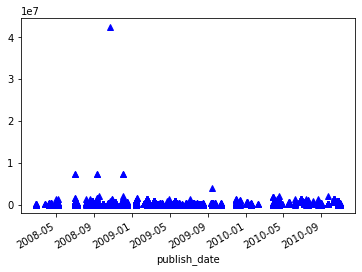

In [5]:
df4 = pd.merge(df3, contracts, on='supplier_name', how='inner')

df4['publish_date'] = pd.to_datetime(df4['publish_date'], format = '%Y-%m')

df4 = df4[df4['agency_name'] == AGENCY]

df4 = df4[(df4['publish_date'] >= '2008-01-01') & 
          (df4['publish_date'] < '2011-01-01') 
          ]

df4 = df4.set_index('publish_date')

df4['value_s'].plot(style='b^')

It would be nice to check the above data for correlations with donations, but the timing of donations is over long periods (many years). 

However, using Resource2 we might be able to check if the awarding of government contracts coincides in time with the passing of certain bills in parliament, which could be connected to ministers of the relevant government department.